# **Project**

# 1. Imports

In [35]:
import pandas as pd
import nltk
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score

nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Dataset load

In [36]:
# Add the dataset the sample_data folder (on the left side)

# Load the dataset
train = pd.read_csv('/content/sample_data/train.txt', sep='\t', names=['title', 'from', 'genre', 'director', 'plot'])
# Combine all relevant text features into one column
train['combined_text'] = train['title'] + ' ' + train['from'] + ' ' + train['director'] + ' ' + train['plot']

X = train['combined_text']
y = train['genre']
#x_test = test['title', 'form', 'director', 'plot']


# Inspect the first few rows
print(train.head())

                       title       from    genre       director  \
0               Ela Cheppanu     Telugu  romance         Ramana   
1  A Nightmare on Elm Street   American   horror   Samuel Bayer   
2            American Gothic   American   horror     John Hough   
3                       Gang  Bollywood    crime    Mazhar Khan   
4         Intimate Relations    British    drama  Charles Frank   

                                                plot  \
0  Sekhar (Tarun) is a graduate from IIM and work...   
1  Kris Fowles (Katie Cassidy) goes to the Spring...   
2  Cynthia is traumatized by the death of her bab...   
3  Four friends, Gangu (Jackie Shroff), Abdul (Na...   
4  Crisis in a middle-class family when the son f...   

                                       combined_text  
0  Ela Cheppanu Telugu Ramana Sekhar (Tarun) is a...  
1  A Nightmare on Elm Street American Samuel Baye...  
2  American Gothic American John Hough Cynthia is...  
3  Gang Bollywood Mazhar Khan Four frien

# 3. Pre-processing

In [37]:
# Pre-processing elements

stop = stopwords.words('english')
including = ['no', 'nor', 'not', 'but', 'against', 'only']
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def apply_preprocessing(text):

  lowered = text.lower()
  # Remove everything that is not a word or inside parenthesis
  lowered_re = re.sub(r'[^a-zA-Z\s]', '', lowered)
  tokens = word_tokenize(lowered_re, "english")

  # Remove ponctuation
  for token in tokens:
        if(all(char in string.punctuation for char in token)):
            tokens.remove(token)

  filtered_tokens = [word for word in tokens if (word not in stop or word in including)]

  processed_tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in filtered_tokens]

  return ' '.join(processed_tokens)


# Apply preprocessing
X = X.apply(apply_preprocessing)

# spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=1)


#print(train.isnull().sum())
print(X.head())

0    ela cheppanu telugu ramana sekhar tarun gradua...
1    nightmar elm street american samuel bayer kri ...
2    american gothic american john hough cynthia tr...
3    gang bollywood mazhar khan four friend gangu j...
4    intim relat british charl frank crisi middlecl...
Name: combined_text, dtype: object


# 4. Apply Naive Bayes

In [38]:
# Create a pipeline with custom tokenizer
nb_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Parameters for grid search
parameters = {
    'vect__max_features': [1000, 3000, 5000, 10000, 15000, 20000],
    'tfidf__use_idf': [True, False],
    'clf__alpha': [0.1, 0.2, 0.5, 1.0],
}

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=10)

# Perform Grid Search
grid_search = GridSearchCV(nb_pipeline, parameters, cv=skf)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.1, 0.2, 0.5, 1.0],
                         'tfidf__use_idf': [True, False],
                         'vect__max_features': [1000, 3000, 5000, 10000, 15000,
                                                20000]})

# 5. Evaluation


In [39]:
# Get the best classifier and make predictions
best_classifier = grid_search.best_estimator_
y_test_pred = best_classifier.predict(X_test)

# Display best parameters
print(grid_search.best_params_)

# Classification report and accuracy score
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Accuracy Score:", accuracy_score(y_test, y_test_pred))

{'clf__alpha': 0.1, 'tfidf__use_idf': False, 'vect__max_features': 5000}
Classification Report:
              precision    recall  f1-score   support

      action       0.73      0.74      0.73        69
   animation       0.93      0.68      0.78        40
      comedy       0.67      0.53      0.59        81
       crime       0.57      0.32      0.41        41
       drama       0.52      0.73      0.61       122
      horror       0.77      0.86      0.81        92
     romance       0.68      0.62      0.65        63
      sci-fi       1.00      0.33      0.50        18
     western       0.89      0.94      0.91        68

    accuracy                           0.69       594
   macro avg       0.75      0.64      0.67       594
weighted avg       0.71      0.69      0.69       594

Accuracy Score: 0.6919191919191919


# 6. Confusion Matrix

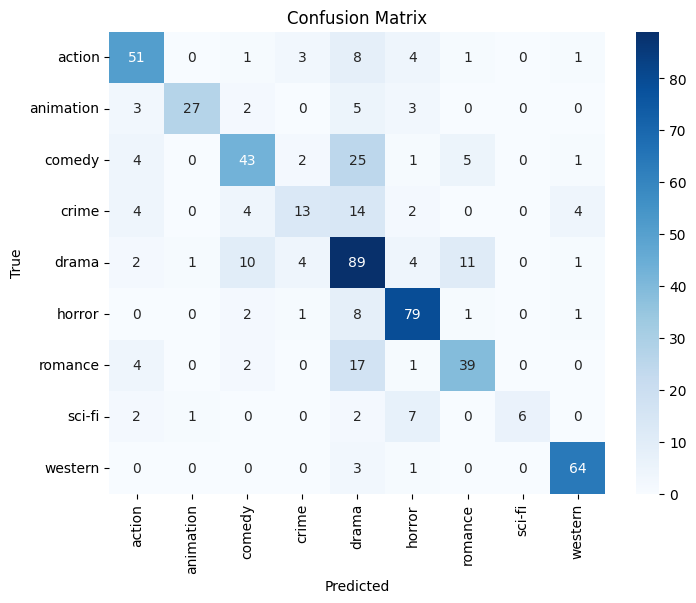

In [40]:
# # Do the matrix of confusion

# Get the confusion matrix
matrix = confusion_matrix(y_test, y_test_pred)

# Ensure labels match the actual classes in your y_test
labels = best_classifier.classes_  # This automatically gets the correct class labels from the classifier

# Plot the heatmap
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()